In [1]:
import numpy as np
import pandas as pd

# We'll use scipy.optimize.curve_fit to do the nonlinear regression
import scipy.optimize

import altair as alt

In [3]:
df=pd.read_csv('data/bcd_gradient.csv',comment="#")
df = df.rename(columns={"[bcd] (a.u.)":'bcd'})
df.head()

,fractional distance from anterior,bcd
0,0.002645,0.863097
1,0.034223,0.863097
2,0.068446,0.745727
3,0.102629,0.654875
4,0.134207,0.545114


In [5]:
dots=alt.Chart(df
    ).mark_point(
    ).encode(
        x='fractional distance from anterior:Q',
        y=alt.Y('bcd:Q', title='bcd intensity (a.u.)',scale=alt.Scale(domain=[0,1])))

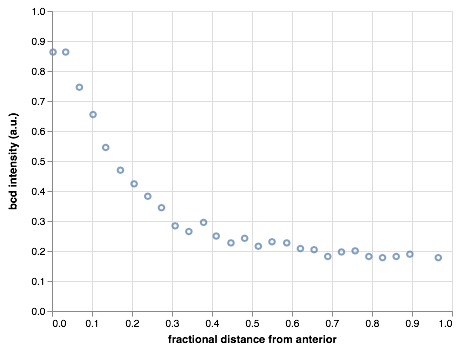

In [6]:
dots

In [7]:
scipy.optimize.curve_fit?

Signature: scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``

Parameters
----------
f : callable
    The model function, f(x, ...).  It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
    The independent variable where the data is measured.
ydata : M-length sequence
    The dependent data --- nominally f(xdata, ...)
p0 : None, scalar, or N-length sequence, optional
    Initial guess for the parameters.  If None, then the initial
    values will all be 1 (if the number of parameters for the function
    can be determined using introspection, otherwise a ValueError
    is raised).
sigma : None or M-length sequ

In [22]:
def bcd_gradient_model_first_try(x,I_0,a,lam):
    return a + I_0 * np.exp(-x/lam)

In [17]:
def bcd_gradient_model(x,I_0,a,lam):
    if np.any(x<0):
        raise RuntimeError("All values of 'x' must be >= zero.")
    if np.any(np.array([I_0,a,lam]) < 0):
        raise RuntimeError('All parameters must be >= zero.')
              
    return a + I_0 * np.exp(-x/lam)


In [24]:
I_0_guess=0.7
a_guess=0.2
lam_guess=0.3 # 1.0 #

p0=np.array([I_0_guess,a_guess,lam_guess])

In [21]:
# _ awarely ignore it
popt, _ = scipy.optimize.curve_fit(bcd_gradient_model,df['fractional distance from anterior'],df['bcd'],p0=p0)
# either delete the testing or change better initial value or transform to log scale

RuntimeError: All parameters must be >= zero.

In [25]:
popt, _ = scipy.optimize.curve_fit(bcd_gradient_model,df['fractional distance from anterior'],df['bcd'],p0=p0)

In [26]:
popt

array([0.76762162, 0.17423312, 0.18712895])

In [28]:
def bcd_gradient_model_log_params(x,log_I_0,log_a,log_lam):
    I_0,a,lam = np.exp(np.array([log_I_0,log_a,log_lam]))
    return bcd_gradient_model(x,I_0,a,lam)

In [29]:
log_p0 = np.log(p0)
log_popt,_=scipy.optimize.curve_fit(bcd_gradient_model_log_params,
                                   df['fractional distance from anterior'],
                                    df['bcd'],
                                    p0=log_p0)
popt=np.exp(log_popt)
popt

array([0.76762146, 0.17423293, 0.18712924])

In [ ]:
# finches: linear regression

In [31]:
df=pd.read_csv('data/grant_complete.csv',comment='#')
df=df.loc[(df['year']==1987) & (df['species']=='scandens'),:]
df=df.drop_duplicates(subset=['band'])
df=df[['beak length (mm)','beak depth (mm)']]

In [33]:
dots=alt.Chart(df
        ).mark_point(
        ).encode(
        alt.X('beak length (mm):Q',scale =alt.Scale(zero=False)),
        alt.Y('beak depth (mm):Q',scale =alt.Scale(zero=False))
        )

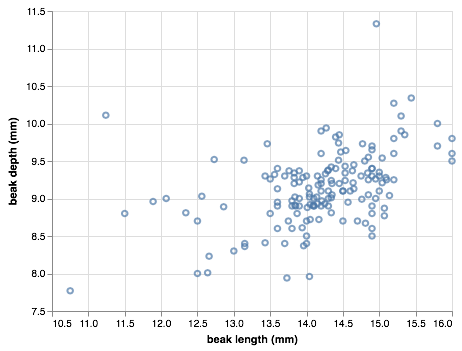

In [34]:
dots

In [35]:
beak_length = df['beak length (mm)'].values
beak_depth = df['beak depth (mm)'].values

In [37]:
# x, y, degree
slope,intercept = np.polyfit(beak_length,beak_depth,deg=1)

In [40]:
# Make a dataframe to plot the regression line
x=np.array([10.5,16.5])
y=slope*x+intercept
df_line = pd.DataFrame({'x':x,'y':y})

reg_line = alt.Chart(df_line
        ).mark_line(
            color='orange'
        ).encode(
            x=alt.X('x:Q',title = 'beak length (mm)', scale=alt.Scale(zero=False)),
            y=alt.X('y:Q',title = 'beak depth (mm)', scale=alt.Scale(zero=False)),
)

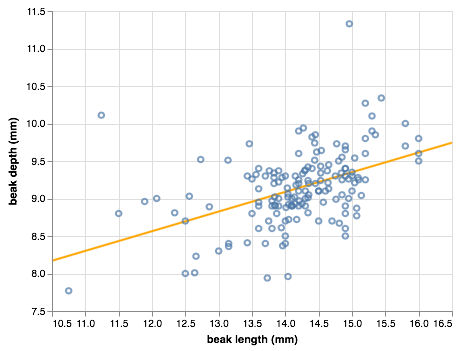

In [41]:
reg_line + dots

In [47]:
# bootstrap here: instead of resample single dim point, we can now resample x-y pairs

def draw_bs_pairs_linreg(x,y,size=1):
    inds = np.arange(len(x))
    
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    for i in range(size):
        bs_inds = np.random.choice(inds,len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope, bs_intercept = np.polyfit(bs_x, bs_y, deg=1)
        
        bs_slope_reps[i], bs_intercept_reps[i] = bs_slope, bs_intercept
        
    return bs_slope_reps, bs_intercept_reps

In [48]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(beak_length, beak_depth, size =100000)

In [49]:
slope, np.percentile(bs_slope_reps,[2.5,97.5])

(0.262258885049905, array([0.14284774, 0.37877245]))

In [ ]:
## plot the confidence intercal out of bootstrap
